Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

- [2023/05/03]   
  We divided this chapter into two parts.
  The first part is up to Topic Modeling

- [2024/04/15]   
  You do not need to restart this notebook when updating the scratch library

- [2024/04/16]   
  The explanation of Gibbs sampling by [(Niemi, 2013)](https://www.youtube.com/watch?v=a_08GKWHFWo) is clear enough and
  also he added an illustration.   
  This is a part of Bayesian Statistics course by Dr. Jared Niemi.   
  The slide for this Gibbs sampling in [here](https://www.jarad.me/courses/stat544/slides/Ch11/Ch11b.pdf)   
  and his full course web page in [here](https://www.jarad.me/courses/stat544/)
  To derive joint probability from conditional distributions in general is very   
  difficult [(Theis, 2014)](https://stats.stackexchange.com/a/130065)   

  A short tutorial on topic modeling by (Blei, 2012) can be watched on YouTube
  [Topic Modeling](https://www.youtube.com/watch?v=DDq3OVp9dNA) and 
  here is the [slides](https://www.cs.columbia.edu/~blei/talks/Blei_MLSS_2012.pdf)


Troubleshooting
- AttributeError: module 'sys' has no attribute 'setcheckinterval'   
  Uninstall and install `tqdm`

In [67]:
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import json
import seaborn as sns

from matplotlib.ticker import MaxNLocator

from bs4 import BeautifulSoup
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Iterable
from IPython.display import display
from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector
from scratch.deep_learning import DeepLearning as dl
from scratch.deep_learning import \
  Tensor, Layer, Sequential, Linear, SoftmaxCrossEntropy, Momentum, \
  GradientDescent

In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

In this chapter we are going to learn how to do computational on a language
dataset

## Word Clouds

Word clouds can be useful to put each word into a contextual space in nice   
looking word cloud with different size rather than in their counts.

<img src="./datasets/neat-word-cloud.png" width=400>

In [4]:
# The following a data sciece-related buzzwords,
# The first number represents how frequently it appear in job posting
# The second number represents how frequently it appears on resumes
data = [ 
  ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50), 
  ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60), 
  ("data science", 60, 70), ("analytics", 90, 3), ("team player", 85, 85), 
  ("dynamic", 2, 90), ("synergies", 70, 0), ("actionable insights", 40, 30), 
  ("think out of the box", 45, 10), ("self-starter", 30, 50), 
  ("customer focus", 65, 15), ("thought leadership", 35, 35)]

In [5]:
# Convert total popularity into text size
def text_size(total: int) -> float:
  """equals 8 if total is 0, 28 if total is 200""" 
  return 8 + total / 200 * 20

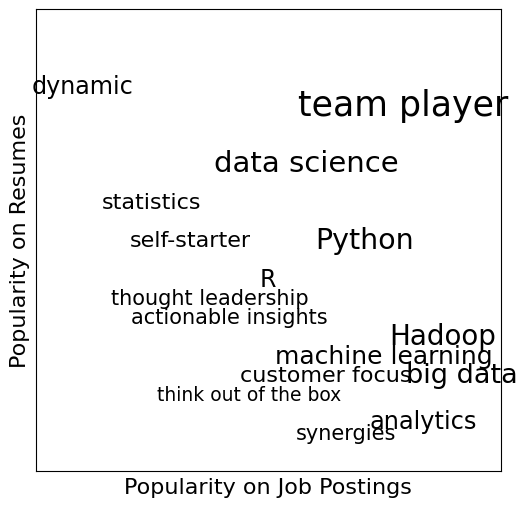

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

for word, job_popularity, resume_popularity in data:
  ax.text(job_popularity, resume_popularity, word, 
          ha="center", va="center", 
          size=text_size(job_popularity + resume_popularity)) 

ax.set_xlabel("Popularity on Job Postings")
ax.set_ylabel("Popularity on Resumes")

ax.set_xlim([-10, 110])
ax.set_ylim([-10, 110])

ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)


## n-Gram Language Models

We have a task to create a bunch of essays by learning a corpus of documents.   
We start with Mike Loukides's essay ["What Is Data Science?"](http://oreil.ly/1Cd6ykN)

This task is motivated obsolete methods by creating many web pages will increase  
your user traffic to your website

In [7]:
# replace unicode character of apostrophes `u\u2019` by literal apostrophes
def fix_unicode(text: str) -> str:
  return text.replace(u"\u2019", "'")

In [8]:
# Get the text
url = "http://radar.oreilly.com/2010/06/what-is-data-science.html"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

# Split the downloaded text into a sequence of words and periods
# We have to update from article-body to entry-content
content = soup.find("div", "entry-content")      # find an entry-content div
regex = r"[\w']+|[\.]"                          # matches a word or a period

document = []
for paragraph in content("p"):
  words = re.findall(regex, fix_unicode(paragraph.text))
  document.extend(words)

document

['Sections',
 'Download',
 'this',
 'free',
 'report',
 "We've",
 'all',
 'heard',
 'it',
 'according',
 'to',
 'Hal',
 'Varian',
 'statistics',
 'is',
 'the',
 'next',
 'sexy',
 'job',
 '.',
 'Five',
 'years',
 'ago',
 'in',
 'What',
 'is',
 'Web',
 '2',
 '.',
 '0',
 'Tim',
 "O'Reilly",
 'said',
 'that',
 'data',
 'is',
 'the',
 'next',
 'Intel',
 'Inside',
 '.',
 'But',
 'what',
 'does',
 'that',
 'statement',
 'mean',
 'Why',
 'do',
 'we',
 'suddenly',
 'care',
 'about',
 'statistics',
 'and',
 'about',
 'data',
 'In',
 'this',
 'post',
 'I',
 'examine',
 'the',
 'many',
 'sides',
 'of',
 'data',
 'science',
 'the',
 'technologies',
 'the',
 'companies',
 'and',
 'the',
 'unique',
 'skill',
 'sets',
 '.',
 'The',
 'web',
 'is',
 'full',
 'of',
 'data',
 'driven',
 'apps',
 '.',
 'Almost',
 'any',
 'e',
 'commerce',
 'application',
 'is',
 'a',
 'data',
 'driven',
 'application',
 '.',
 "There's",
 'a',
 'database',
 'behind',
 'a',
 'web',
 'front',
 'end',
 'and',
 'middleware',
 '

We certainly could (and likely should) clean this data further. 
- There is still some amount of extraneous text in the document (for example,   
  the first word is _Section_ (heading title))
- We've split on midsentence periods (for example, in Web 2.0)
- There is a handful of captions and lists sprinkled throughout

Having said that, we'll work with the document as it is

In [9]:
len(document)

5338

We have to create a *bigrams model* for a given word and count the occurrences
for the next words.

In [10]:
# A transition for bigram
transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
  transitions[prev].append(current)


transitions

defaultdict(list,
            {'Sections': ['Download'],
             'Download': ['this'],
             'this': ['free',
              'post',
              'database',
              'sounds',
              'data',
              'scale',
              'video',
              'difference',
              'animation',
              'is',
              'versatile',
              'into',
              'but'],
             'free': ['report'],
             'report': ["We've", 'from', 'only'],
             "We've": ['all', 'all', 'all'],
             'all': ['heard',
              'the',
              'of',
              'of',
              'carefully',
              'the',
              'in',
              'equipment',
              "you're",
              'heard',
              'data',
              'of',
              'heard',
              'locked',
              'at',
              'trying',
              'aspects',
              'tapped',
              'The'],
             'heard': ['it'

In [11]:
transitions["."]   # Start words for bigrams

['Five',
 '0',
 'But',
 'The',
 'Almost',
 "There's",
 'But',
 'A',
 "It's",
 'Data',
 'One',
 'The',
 'Gracenote',
 'If',
 'Before',
 'If',
 'While',
 'Their',
 'CDDB',
 'Google',
 "Here's",
 'Google',
 'Facebook',
 'Amazon',
 'These',
 'They',
 'The',
 'Whether',
 "That's",
 'In',
 'Whether',
 'And',
 "It's",
 'Data',
 'The',
 'Using',
 'What',
 "We're",
 'To',
 'Data',
 'While',
 'At',
 'Sites',
 'Factual',
 '1956',
 'It',
 'In',
 '5',
 'Photo',
 'Disk',
 '0',
 'The',
 'Mobile',
 'Point',
 'All',
 'Since',
 '6',
 'But',
 'RAM',
 'Hitachi',
 'Whether',
 'The',
 'Data',
 'The',
 'The',
 'Increased',
 "That's",
 'So',
 'We',
 'But',
 'Many',
 'They',
 'The',
 'This',
 'If',
 'Data',
 "You're",
 'It',
 'To',
 'Scripting',
 'Once',
 'Data',
 'If',
 'If',
 'In',
 "It's",
 'If',
 'Roger',
 'While',
 'To',
 'And',
 'Try',
 'Google',
 'Disambiguation',
 'When',
 "That's",
 'If',
 'For',
 '01',
 'If',
 '01',
 "We've",
 'Oil',
 'And',
 'The',
 "We're",
 'At',
 'What',
 'Information',
 'They',


In [12]:
# Generate a sentence
def generate_using_bigrams(rng) -> str:
  current = "."       # this means the next word will start a sentence
  result = []
  while True:
    next_word_candidates = transitions[current]   # bigram (current, _)
    current = rng.choice(next_word_candidates)    # choose one at random

    result.append(current)
    if current == ".":
      return " ".join(result)

In [13]:
# seed = 2023_05_03
seed = None
rng = np.random.default_rng(seed)
generate_using_bigrams(rng)

'It then combine publishing industry is only useful The developers have found a holistic approach which cover topics as clean as applied to many of data In the English .'

The above generated sentence is gibberish. We try to improve it using 
*n-grams model*

In [14]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next_ in zip(document, document[1:], document[2:]):
  if prev == ".":               # if the previous "word" was a period
    starts.append(current)      # then this is a start word

  trigram_transitions[(prev, current)].append(next_)

trigram_transitions

defaultdict(list,
            {('Sections', 'Download'): ['this'],
             ('Download', 'this'): ['free'],
             ('this', 'free'): ['report'],
             ('free', 'report'): ["We've"],
             ('report', "We've"): ['all'],
             ("We've", 'all'): ['heard', 'heard', 'heard'],
             ('all', 'heard'): ['it', 'a', 'the'],
             ('heard', 'it'): ['according'],
             ('it', 'according'): ['to'],
             ('according', 'to'): ['Hal'],
             ('to', 'Hal'): ['Varian'],
             ('Hal', 'Varian'): ['statistics'],
             ('Varian', 'statistics'): ['is'],
             ('statistics', 'is'): ['the', 'that', 'the'],
             ('is', 'the'): ['next',
              'next',
              'direct',
              'Hadoop',
              'grammar',
              'classic',
              'state',
              'heart'],
             ('the', 'next'): ['sexy', 'Intel', 'generation', 'decades'],
             ('next', 'sexy'): ['job'],
     

In [15]:
starts

['Five',
 '0',
 'But',
 'The',
 'Almost',
 "There's",
 'But',
 'A',
 "It's",
 'Data',
 'One',
 'The',
 'Gracenote',
 'If',
 'Before',
 'If',
 'While',
 'Their',
 'CDDB',
 'Google',
 "Here's",
 'Google',
 'Facebook',
 'Amazon',
 'These',
 'They',
 'The',
 'Whether',
 "That's",
 'In',
 'Whether',
 'And',
 "It's",
 'Data',
 'The',
 'Using',
 'What',
 "We're",
 'To',
 'Data',
 'While',
 'At',
 'Sites',
 'Factual',
 '1956',
 'It',
 'In',
 '5',
 'Photo',
 'Disk',
 '0',
 'The',
 'Mobile',
 'Point',
 'All',
 'Since',
 '6',
 'But',
 'RAM',
 'Hitachi',
 'Whether',
 'The',
 'Data',
 'The',
 'The',
 'Increased',
 "That's",
 'So',
 'We',
 'But',
 'Many',
 'They',
 'The',
 'This',
 'If',
 'Data',
 "You're",
 'It',
 'To',
 'Scripting',
 'Once',
 'Data',
 'If',
 'If',
 'In',
 "It's",
 'If',
 'Roger',
 'While',
 'To',
 'And',
 'Try',
 'Google',
 'Disambiguation',
 'When',
 "That's",
 'If',
 'For',
 '01',
 'If',
 '01',
 "We've",
 'Oil',
 'And',
 'The',
 "We're",
 'At',
 'What',
 'Information',
 'They',


In [16]:
def generate_using_trigrams(rng) -> str:
  current = rng.choice(starts)
  prev = "."
  result = [current]
  while True:
    next_word_candidates = trigram_transitions[(prev, current)]
    next_word = rng.choice(next_word_candidates)

    prev, current = current, next_word
    result.append(current)

    if current == ".":
      return " ".join(result)

In [17]:
# seed = 2023_05_01
seed = None
rng = np.random.default_rng(seed)
generate_using_trigrams(rng)

"You're likely to be able to spot trends in the database including a CD you've taken advantage of this database ."

## Grammars

In [18]:
# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

# _S  : sentence
# _NP : noun phrase
# _VP : verb phrase 
# _N  : noun
# _A  : adjective
# _P  : preposition (e.g.: "in", "at", "on", "of", and "to")
# _V  : verb
# all the rule without _ (underscore) is a terminal (no need to expand)
grammar = {
  "_S"  : ["_NP _VP"],
  "_NP" : ["_N", "_A _NP _P _A _N"],
  "_VP" : ["_V", "_V _NP"],
  "_N"  : ["data science", "Python", "regression"],
  "_A"  : ["big", "linear", "logistic"],
  "_P"  : ["about", "near"],
  "_V"  : ["learns", "trains", "tests", "is"]
}

In [19]:
# A helper function to identify a terminals
def is_terminal(token: str) -> bool:
  return token[0] != "_"

In [20]:
# Expand a list of token into a sentence using given grammar
def expand(grammar: Grammar, tokens: List[str], rng, verbose=False) -> List[str]:
  if verbose:
    print(tokens)

  for i, token in enumerate(tokens):
    # If this is a terminal token, skip it.
    #print(token)
    if is_terminal(token):
      continue

    # Otherwise, it's a nonterminal token,
    # so we need to choose a replacement at random.
    replacement = rng.choice(grammar[token])

    if is_terminal(replacement):
      tokens[i] = replacement
    else:
      # Replacement could be, e.g., "_NP _VP", so we need to
      # split it on spaces and splice it in.
      tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

    # Now call expand on the new list of tokens
    return expand(grammar, tokens, rng, verbose=verbose)
  
  # If we get here, we had all terminals and are done.
  return tokens, rng

In [21]:
def generate_sentence(grammar: Grammar, rng, verbose=False) -> List[str]:
  return expand(grammar, ["_S"], rng, verbose=verbose)

In [22]:
seed = 2023_05_02 
# seed = None
rng = np.random.default_rng(seed)

generate_sentence(grammar, rng, verbose=True);


['_S']
['_NP', '_VP']
['_N', '_VP']
['Python', '_VP']
['Python', '_V', '_NP']
['Python', 'trains', '_NP']
['Python', 'trains', '_N']
['Python', 'trains', 'data science']


Using data science to generate text is a neat trick; using it to *understand*
text is more magical.

## An Aside: Gibbs Sampling

In general, some distributions are harder to sample from. Gibbs sampling helps   
us with a technique for generating samples from multidimensional distributions   
when we only know some of the conditional distributions

### Example: rolling two dices

$x$: the value of the first dice     
$y$: the sum of the dices.

The distribution of $y$ conditional on $x$: 
$x + 1$, $x + 2$, $x + 3$, $x + 4$, $x + 5$, $x + 6$

The distribution of $x$ conditional on $y$ is more complicated:
- if $y = 2$, then it is necessary that $x = 1$
- if $y = 3$, then it is necessary and equally likely that $x = 1$ or $x = 2$
- if $y = 4$, then it is necessary and equally likely that $x = 1$ or $x = 2$ or $x = 3$
- ...
- if $y = 11$, then  it is necesasry and equally likely that $x = 5$ or $x = 6$
- if $y = 12$, the it is necesasry that $x = 6$

| $y$ | $x$ |
|-----|-----|
| 2   | [1] |
| 3   | [1, 2] |
| 4   | [1, 2, 3] |
| 5   | [1, 2, 3, 4] |
| 6   | [1, 2, 3, 4, 5] | 
| 7   | [1, 2, 3, 4, 5, 6] |
| 8   | [2, 3, 4, 5, 6] | 
| 9   | [3, 4, 5, 6] |
| 10  | [4, 5, 6] |
| 11  | [5, 6] |
| 12  | [6] |

In [23]:
def roll_a_dice(rng) -> int:
  return rng.choice([1, 2, 3, 4, 5, 6]) 

def direct_sample(rng) -> Tuple[int, int]:
  d1 = roll_a_dice(rng)
  d2 = roll_a_dice(rng)
  return d1, d1 + d2

def random_y_given_x(x: int, rng) -> int:
  """equally likely to be x + 1, x + 2, ..., x + 6""" 
  return x + roll_a_dice(rng)

def random_x_given_y(y: int, rng) -> int:
  # The minimum of y must be 2 where both dices are 1
  if y <= 7:
    # if the total is 7 or less, the first dice is equally likely to be
    # 1, 2, ..., (total - 1)
    return rng.integers(1, y)

  else:
    # if the total is 7 or more, the first dice is equally likely to be
    # (total - 6), (total - 5), ..., 6
    return rng.integers(y - 6, 7)

In [24]:
seed = 2023_05_03
rng = np.random.default_rng(seed)

x_data_dice = [roll_a_dice(rng) for _ in range(10)]
display(x_data_dice)

xy_data_dice = [direct_sample(rng) for _ in range(10)]
display(xy_data_dice)

display([random_y_given_x(x, rng) for x in x_data_dice])

display([random_x_given_y(y, rng) for y in np.array(xy_data_dice)[:,1]])

[5, 4, 4, 2, 4, 2, 4, 6, 3, 6]

[(2, 5),
 (2, 7),
 (5, 8),
 (5, 9),
 (2, 7),
 (4, 6),
 (3, 7),
 (1, 4),
 (3, 5),
 (1, 7)]

[10, 6, 7, 5, 9, 8, 7, 7, 6, 10]

[2, 1, 2, 3, 2, 3, 1, 1, 1, 2]

In real case, what we have is conditional probabilities to generate $y$ or $x$.
Then we can use gibbs sampling to generate all pairs of $x$ and $y$

In [25]:
def gibbs_sample(rng, num_iters: int = 100) -> Tuple[int, int]:
  x, y = 1, 2      # initial values do not really matter
  for _ in range(num_iters):
    x = random_x_given_y(y, rng)
    y = random_y_given_x(x, rng)

  return x, y

In [26]:
# Compare the distribution generated by Gibbs sample and and direct sample
def compare_distributions(rng, num_samples: int = 1000) \
  -> Dict[int, List[int]]:

  counts = defaultdict(lambda: [0, 0])
  for _ in range(num_samples):
    counts[gibbs_sample(rng)][0] += 1
    counts[direct_sample(rng)][1] += 1

  return counts

In [27]:
seed = 2023_05_03
rng = np.random.default_rng(seed)
comparison = compare_distributions(rng, num_samples=10_000)   # 21 secs

In [28]:
comparison_keys = comparison.keys()
comparison_vals = list(comparison.values())

gibbs_sample_count = np.array(comparison_vals)[:,0]
direct_sample_count = np.array(comparison_vals)[:,1]

In [29]:
comparison[(4,5)]

[297, 259]

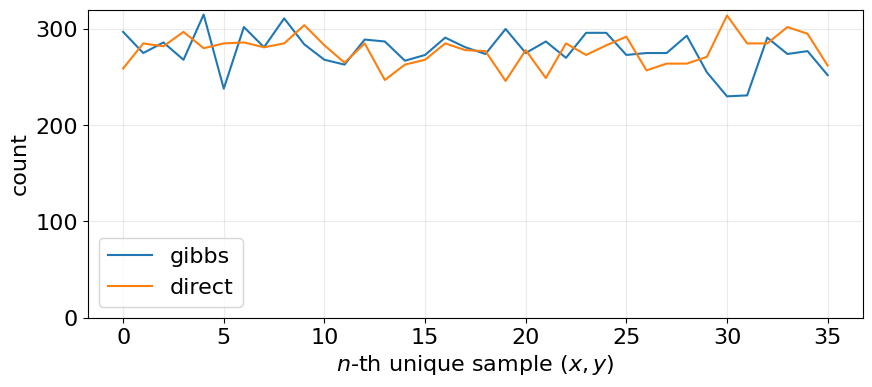

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(gibbs_sample_count, label="gibbs")
ax.plot(direct_sample_count, label="direct")

ax.set_ylim([0, 320])

ax.set_ylabel("count")
ax.set_xlabel("$n$-th unique sample $(x, y)$")
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)

Without Gibbs sampling, we failed to produce uniform distribution for $(x, y)$   
when we sampled $x$ from the conditional distribution $P(x|y)$ and $y$ is given
by the uniform distribution

In [31]:
seed = 24_04_16
rng = np.random.default_rng(seed)

N_samples = 10_000
y_rand = rng.integers(2, 13, size=N_samples)
x_rand = np.array([random_x_given_y(y, rng) for y in y_rand])

counts_random_x_given_y = defaultdict(lambda: 0)
for x, y in zip(x_rand, y_rand):
  counts_random_x_given_y[(x, y)] += 1

counts_random_x_given_y

defaultdict(<function __main__.<lambda>()>,
            {(2, 3): 421,
             (6, 12): 933,
             (1, 5): 227,
             (4, 10): 314,
             (1, 3): 457,
             (1, 2): 937,
             (4, 5): 246,
             (3, 7): 157,
             (3, 9): 221,
             (5, 8): 198,
             (6, 11): 431,
             (3, 5): 231,
             (4, 6): 184,
             (6, 8): 183,
             (4, 9): 217,
             (1, 6): 185,
             (5, 9): 242,
             (2, 4): 264,
             (6, 9): 213,
             (1, 7): 155,
             (4, 7): 151,
             (5, 10): 293,
             (2, 8): 192,
             (6, 10): 286,
             (5, 11): 447,
             (6, 7): 162,
             (4, 8): 178,
             (1, 4): 300,
             (2, 6): 192,
             (5, 7): 158,
             (3, 8): 174,
             (2, 7): 168,
             (3, 6): 195,
             (3, 4): 315,
             (5, 6): 158,
             (2, 5): 215})

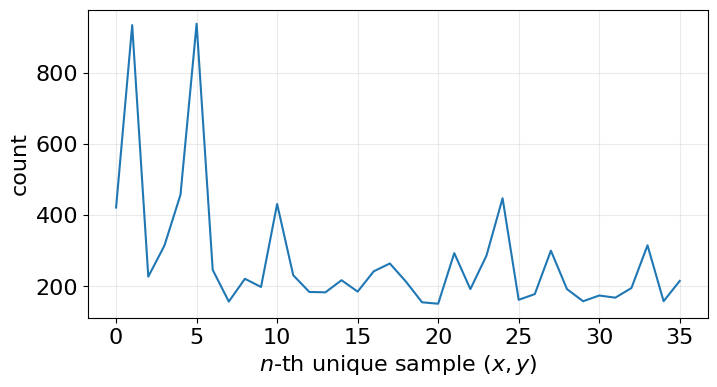

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(list(counts_random_x_given_y.values()))

ax.grid("on")
ax.set_xlabel("$n$-th unique sample $(x, y)$")
ax.set_ylabel("count")

plt.show(fig)

Now, we take a look inside Gibbs sample function `gibbs_sample()`


In [33]:
def gibbs_sample_with_history(rng, num_iters: int = 100) -> Tuple[int, int]:
  x, y = 1, 2      # initial values do not really matter
  x_y_hist = [[x, y]]
  for _ in range(num_iters):
    x = random_x_given_y(y, rng)
    y = random_y_given_x(x, rng)
    x_y_hist.append([x, y])

  return x, y, np.array(x_y_hist)

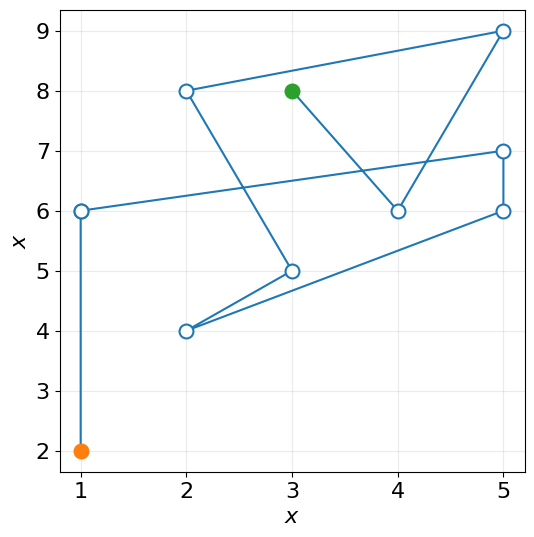

In [34]:
seed = 24_03_31
# seed = None
rng = np.random.default_rng(seed)
_, _, x_y_hist = gibbs_sample_with_history(rng, 10)
x_y_hist

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(x_y_hist[:, 0], x_y_hist[:, 1], marker="None")
ax.plot(x_y_hist[1:-1, 0], x_y_hist[1:-1, 1], marker="o", markerfacecolor="w",
        markeredgewidth=1.5, markersize=10, linestyle="None", color="tab:blue")

ax.plot(x_y_hist[0, 0], x_y_hist[0, 1], marker="o", markerfacecolor="tab:orange",
        markeredgewidth=1.5, markersize=10)
ax.plot(x_y_hist[-1, 0], x_y_hist[-1, 1], marker="o", markerfacecolor="tab:green",
        markeredgewidth=1.5, markersize=10)

ax.grid("on")
ax.set_xlabel("$x$")
ax.set_ylabel("$x$")

plt.show(fig)

generate all pairs $(x, y)$ using Gibbs sampling

In [35]:
seed = 24_03_31
rng = np.random.default_rng(seed)

N_samples = 10_000
x_y_gibbs_sampling = np.array([gibbs_sample(rng, num_iters=10) for _ in range(N_samples)])

data_count = np.zeros([6, 11], dtype=int)

for x, y in x_y_gibbs_sampling:
  data_count[x-1, y-2] += 1

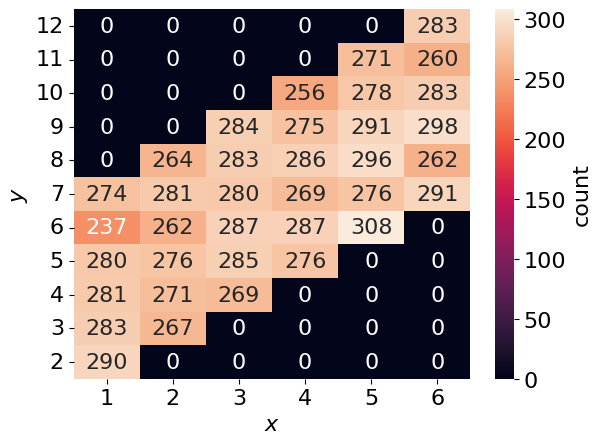

In [36]:
fig, ax = plt.subplots()

sns.heatmap(data_count.T, ax=ax, yticklabels=np.arange(2, 13),
            xticklabels=np.arange(1, 7), annot=True, fmt="d",
            cbar_kws=dict(label="count"))
ax.invert_yaxis()
ax.tick_params(axis="y", labelrotation=0)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.show(fig)


## Topic Modeling

A better tutorial on topic modeling by Serano Academy
- https://www.youtube.com/watch?v=T05t-SqKArY
- https://www.youtube.com/watch?v=BaM1uiCpj_E


Se all so the notes that I created in drawio file: [npl.drawio](./img-resources/nlp.drawio)

The following model uses LDA (Latent Dirichlet Allocation) to identify 
the topics that underlies documents.

LDA has some similarities to the Naive Bayes classifier in that it assumes  
a probabilistic model for documents.

The following assumptions is not detail enough in mathematical perspective 
for LDA technique:
1. There is some fixed number $K$ of topics
2. There is a random variable that assigns each topic an associated distribution   
   over words. You should think of this distribution as the probability of   
   seeing word $w$ given topic $k$.
3. There is another random variable that assigns each document a probability   
   distribution over topics. You should think of this distribution as the   
   mixture of topics in document $d$.
4. Each word in a document was generated by first randomly picking a topic   
   (from document's distribution of topics) and then randomly picking a word   
   (from the topic's distribution of words)


From the given documents, we can estimate the likelihood that topic 1
produces a certain word $w$

$$
\frac{\text{How many times topic 1 produces word $w$}}{
      \text{How many times topic 1 produces any word}}
$$

Gibbs sampling is used when we want to generate the distribution over topics
for a specific word by sampling the topics for the word.

In [111]:
# A function to randomly choose an index based on an arbitrary set of weights
# If we give the function with weight [1, 1, 3], then one-fifth of the time
# it will return 0, one-fifth of the time it will return 1, and three fifth
# of the time it will return 2. Five is from 1 + 1 + 3 = 5.
def sample_from(weights: List[float], rng) -> int:
  """returns i with probability weights[i] / sum(weights)""" 
  total = sum(weights)
  rnd = total * rng.random()        # uniform between 0 and total
  for i, w in enumerate(weights):   
    rnd -= w                        # return the smallest i such that
    if rnd <= 0:                    # weights[0] + ... + weights[i] >= rnd
      return i

In [112]:
# A test script

# Draw 1000 times and count
seed = 2023_05_03
rng = np.random.default_rng(seed)
draws = Counter(sample_from([0.1, 0.1, 0.8], rng) for _ in range(1000))

print(draws)
assert 10 < draws[0] < 190    # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190    # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950   # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

Counter({2: 790, 1: 111, 0: 99})


In [113]:
# Our documents are our user's interests
documents = [
  ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
  ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
  ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
  ["R", "Python", "statistics", "regression", "probability"],
  ["machine learning", "regression", "decision trees", "libsvm"],
  ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
  ["statistics", "probability", "mathematics", "theory"],
  ["machine learning", "scikit-learn", "Mahout", "neural networks"],
  ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
  ["Hadoop", "Java", "MapReduce", "Big Data"],
  ["statistics", "R", "statsmodels"],
  ["C++", "deep learning", "artificial intelligence", "probability"],
  ["pandas", "R", "Python"],
  ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
  ["libsvm", "regression", "support vector machines"]
]

# With the number of topics
K = 4


Create data structures to keep track some counters when calculating
sampling weights

In [114]:
# How many times each topic is assigned to each document

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

In [115]:
# How many times each word is assigned to each topic

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

In [116]:
# The total number of words assigned to each topic

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

In [117]:
# The total number of words contained in each document:

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

In [118]:
# The number of distinct words
distinct_words = set(word for document in documents 
                      for word in document)
W = len(distinct_words)

In [119]:
# The number of documents
D = len(documents)

Now we define our conditional probability functions. See the description of    
this formula in [nlp.drawio](./img-resources/nlp.drawio)

$$
\begin{gather*}
  p(\theta_d)\Big|_{\texttt{topic}} \approx
       \frac{\texttt{document\_topic\_counts[d][topic]} + \alpha}{
             \texttt{document\_lengths[d]} + K\alpha} \\[12pt]
    p(\beta_i)\Big|_{\texttt{word}} \approx
       \frac{\texttt{topic\_word\_counts[topic][word]} + \gamma}{
               \texttt{topic\_counts[topic]} + W\gamma}  \qquad (i \text{ is an index for }\texttt{topic})
\end{gather*}
$$

$\alpha$ and $\gamma$ are the _pseudocounts_ to avoid zero probability (see Chapter 13)

In [46]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
  """The fraction of words in document `d` that are assigned to 
     `topic` (plus some smoothing alpha or pseudcount see chapter 13)""" 
  return ((document_topic_counts[d][topic] + alpha) 
           / (document_lengths[d] + K * alpha))


def p_word_given_topic(word: str, topic: int, gamma: float = 0.1) -> float:
  """The fraction of words assigned to `topic` that equal `word` (plus some 
     smoothing beta or pseudocount see chapter 13)""" 
  return ((topic_word_counts[topic][word] + gamma) 
          / (topic_counts[topic] + W * gamma))

Use the above conditional probability function to create the weights for   
updating topics

There is a solid mathematica description why `topic_weight` is defined like the    
below function. For the practical purpose, we skip it.  

We can learn more from the mentioned above videos (Serano academy) and   
an introductory article of topic modeling by [(Blei, 2012) - Probabilistic Topic Models](https://www.cs.columbia.edu/~blei/papers/Blei2012.pdf)

$$
  \texttt{topic\_weight(d, word, k)} = p(\beta_k)\Big|_{\texttt{word}} \,\, p(\theta_d)\Big|_{\texttt{topic} = k}
$$

In [47]:
def topic_weight(d: int, word: str, k: int) -> float:
  """Given a document and a word in that document, return the weight for 
     the kth topic"""
  return p_word_given_topic(word, topic) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str, rng) -> int:
  return sample_from([topic_weight(d, word, k) for k in range(K)], rng)

### Variable definition for topic structures and Initialization procedures

We start by assigning every word to a random topic and populating
our counters appropriately

In [218]:
seed = 2023_05_03
rng = np.random.default_rng(seed)
document_topics = [[rng.integers(K) for word in document]
                      for document in documents]

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

# The number of distinct words
distinct_words = set(word for document in documents 
                      for word in document)
W = len(distinct_words)

# The number of documents
D = len(documents)

for d in range(D):
  for word, topic in zip(documents[d], document_topics[d]):
    document_topic_counts[d][topic] += 1
    topic_word_counts[topic][word] += 1
    topic_counts[topic] += 1

In [219]:
print(document_lengths)

print(len(distinct_words), sorted(distinct_words))

display(document_topic_counts)

display(topic_word_counts)

display(topic_counts)

[7, 5, 6, 5, 4, 6, 4, 4, 4, 4, 3, 4, 3, 5, 3]
36 ['Big Data', 'C++', 'Cassandra', 'HBase', 'Hadoop', 'Haskell', 'Java', 'Mahout', 'MapReduce', 'MongoDB', 'MySQL', 'NoSQL', 'Postgres', 'Python', 'R', 'Spark', 'Storm', 'artificial intelligence', 'databases', 'decision trees', 'deep learning', 'libsvm', 'machine learning', 'mathematics', 'neural networks', 'numpy', 'pandas', 'probability', 'programming languages', 'regression', 'scikit-learn', 'scipy', 'statistics', 'statsmodels', 'support vector machines', 'theory']


[Counter({2: 5, 0: 1, 1: 1}),
 Counter({3: 2, 1: 2, 0: 1}),
 Counter({2: 4, 0: 1, 1: 1}),
 Counter({1: 3, 3: 1, 2: 1}),
 Counter({1: 2, 2: 1, 0: 1}),
 Counter({0: 3, 3: 1, 2: 1, 1: 1}),
 Counter({1: 2, 3: 2}),
 Counter({1: 2, 0: 1, 2: 1}),
 Counter({0: 3, 1: 1}),
 Counter({1: 2, 0: 2}),
 Counter({1: 2, 0: 1}),
 Counter({3: 2, 0: 2}),
 Counter({1: 2, 0: 1}),
 Counter({0: 4, 1: 1}),
 Counter({3: 2, 1: 1})]

[Counter({'Java': 2,
          'HBase': 2,
          'Python': 2,
          'Big Data': 2,
          'regression': 1,
          'R': 1,
          'Haskell': 1,
          'machine learning': 1,
          'neural networks': 1,
          'deep learning': 1,
          'statsmodels': 1,
          'artificial intelligence': 1,
          'probability': 1,
          'pandas': 1,
          'databases': 1,
          'Postgres': 1,
          'MySQL': 1}),
 Counter({'R': 3,
          'MongoDB': 2,
          'libsvm': 2,
          'statistics': 2,
          'Storm': 1,
          'Postgres': 1,
          'numpy': 1,
          'regression': 1,
          'probability': 1,
          'decision trees': 1,
          'programming languages': 1,
          'theory': 1,
          'scikit-learn': 1,
          'neural networks': 1,
          'artificial intelligence': 1,
          'Hadoop': 1,
          'MapReduce': 1,
          'Python': 1}),
 Counter({'Hadoop': 1,
          'Big Data': 1,
          'HBase': 1

[21, 23, 13, 10]

### Exploration to the initial distributions

Initial topic (initial distribution over a fixed vocabulary)

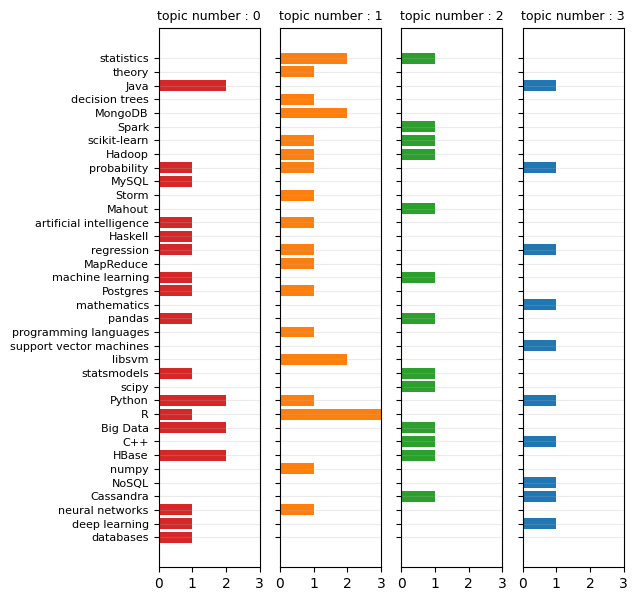

In [220]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 7), sharey=True)

list_distinct_words = list(distinct_words)
color_list = ["tab:red", "tab:orange", "tab:green", "tab:blue"]

for topic_number in range(K):
  word_count = [topic_word_counts[topic_number][word] for word in list_distinct_words]

  axes[topic_number].barh(list_distinct_words, word_count, 
                          color=color_list[topic_number])

  axes[topic_number].set_title(f"topic number : {topic_number}", fontsize=9)

  axes[topic_number].yaxis.grid(True)
  axes[topic_number].set_yticks(np.arange(len(list_distinct_words)))
  axes[topic_number].set_yticklabels(list_distinct_words, rotation=0, ha="right", 
                      fontdict=dict(fontsize=8))
  axes[topic_number].set_xticks(np.arange(4))
  axes[topic_number].set_xticklabels([i for i in range(4)], fontdict=dict(fontsize=10))
  axes[topic_number].set_xlim([0, 3])

plt.subplots_adjust(hspace=0.5)
plt.show(fig)

Make a plot of a single topic over fixed vocabulary

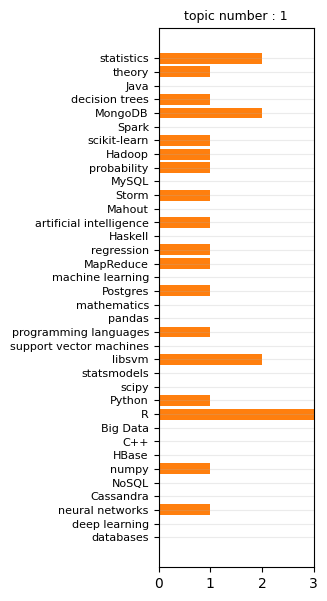

In [221]:
fig, ax = plt.subplots(figsize=(2, 7))

list_distinct_words = list(distinct_words)

topic_number = 1
word_count = [topic_word_counts[topic_number][word] for word in list_distinct_words]

ax.barh(list_distinct_words, word_count, 
        color=color_list[topic_number])

ax.set_title(f"topic number : {topic_number}", fontsize=9)

ax.yaxis.grid(True)
ax.set_yticks(np.arange(len(list_distinct_words)))
ax.set_yticklabels(list_distinct_words, rotation=0, ha="right", 
    fontdict=dict(fontsize=8))
ax.set_xticks(np.arange(4))
ax.set_xticklabels([i for i in range(4)], fontdict=dict(fontsize=10))
ax.set_xlim([0, 3])

plt.subplots_adjust(hspace=0.5)
plt.show(fig)

Create a distribution plot (using `.barh()`) over topic for each document

In [222]:
document_number = 0
print(document_topic_counts[document_number])
sorted(document_topic_counts[document_number].items())

Counter({2: 5, 0: 1, 1: 1})


[(0, 1), (1, 1), (2, 5)]

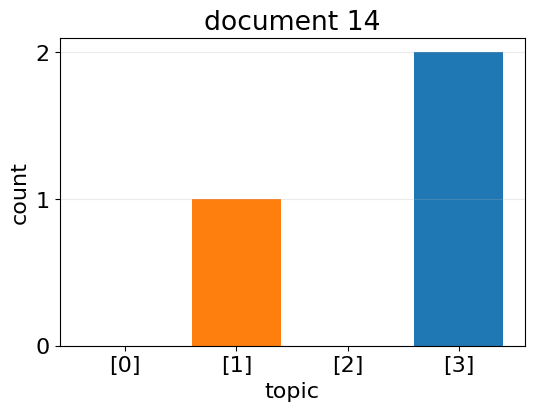

In [223]:
fig, ax = plt.subplots(figsize=(6, 4))

document_number = 14
list_colors = ["tab:red", "tab:orange", "tab:green", "tab:blue"]

document_d_topic_counts = [document_topic_counts[document_number][k] for k in range(K)]

ax.bar(np.arange(4), document_d_topic_counts, color=list_colors)

ax.set_xticks(np.arange(4))
ax.set_xticklabels([f"[{k}]" for k in range(K)])
ax.yaxis.grid(True)
ax.set_ylabel("count")
ax.set_xlabel("topic")
ax.set_title(f"document {document_number:02}")

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show(fig)



Plot topic distribution for all documents in a single plot

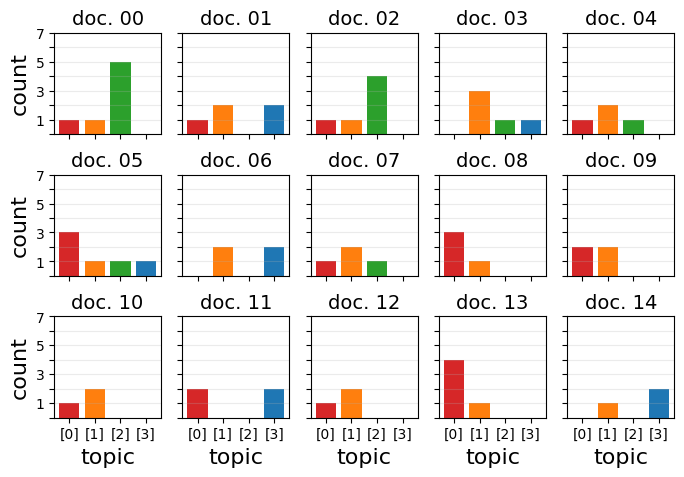

In [224]:
n_rows = 3
n_cols = 5

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, 5),
                          sharex=True, sharey=True)
list_colors = ["tab:red", "tab:orange", "tab:green", "tab:blue"]

for idx, (ax, document_number) in enumerate(zip(axes.flatten(), range(D))):

  document_d_topic_counts = [document_topic_counts[document_number][k] for k in range(K)]

  ax.bar(np.arange(4), document_d_topic_counts, color=list_colors)

  max_y_count = 8
  ax.set_yticks(np.arange(1, max_y_count, 2))
  ax.set_yticklabels([f"{count}" for count in range(1, max_y_count, 2)], fontdict=dict(fontsize=10))
  ax.set_xticks(np.arange(4))
  ax.set_xticklabels([f"[{k}]" for k in range(K)], fontdict=dict(fontsize=10))
  ax.yaxis.grid(True)
  if idx % n_cols == 0:
    ax.set_ylabel("count")
  
  if idx > (n_cols * n_rows - n_cols) - 1: 
    ax.set_xlabel("topic")
  
  ax.set_title(f"doc. {document_number:02}", fontsize=14)

  ax.yaxis.set_major_locator(MaxNLocator(integer=True))


plt.subplots_adjust(hspace=0.4)
plt.show(fig)



We take a look to the matrix that is constructed with `topic_weight`

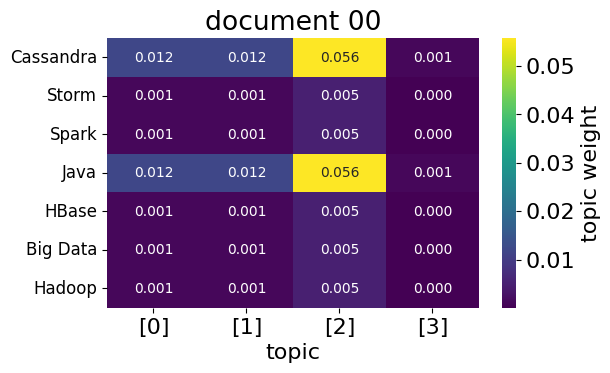

In [183]:
document_number = 0

fig, ax = plt.subplots(figsize=(6, 0.5*document_lengths[document_number]))

show_topic_count = True
# matrix_distinct_words_and_topics = np.zeros([len(distinct_words), K])
matrix_distinct_words_and_topics = np.zeros([document_lengths[document_number], K])

# for w, word in enumerate(distinct_words):
for w, word in zip(range(document_lengths[document_number]), documents[document_number]):
  for k in range(K):
    matrix_distinct_words_and_topics[w][k] = topic_weight(document_number, word, k)

sns.heatmap(matrix_distinct_words_and_topics, ax=ax, yticklabels=documents[document_number],
            xticklabels=np.arange(4), annot=show_topic_count, fmt=".3f",
            annot_kws=dict(fontsize=10),
            cbar_kws=dict(label="topic weight"), cmap="viridis")
ax.invert_yaxis()
ax.tick_params(axis="y", labelrotation=0, labelsize=12)
ax.set_title(f"document {document_number:02d}")

ax.set_xticks(np.arange(4) + 0.5)
ax.set_xticklabels([f"[{d}]" for d in range(4)])
ax.set_xlabel("topic")

plt.show(fig)


### Complete program of LDA


Now we are going to get a joint sample of topics-word distrbution and the   
documents-topic distribution using Gibbs sampling and the conditional   
probabilities defined previously

In [184]:
# We repeat the code above to avoid replacement of variables (topic structures) during the calculation
seed = 2023_05_03  # change the seed, change also the topics definition
rng = np.random.default_rng(seed)
document_topics = [[rng.integers(K) for word in document]
                      for document in documents]
for _ in document_topics:
  print(_)

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

# The number of distinct words
distinct_words = set(word for document in documents 
                      for word in document)
W = len(distinct_words)

# The number of documents
D = len(documents)

for d in range(D):
  for word, topic in zip(documents[d], document_topics[d]):
    document_topic_counts[d][topic] += 1
    topic_word_counts[topic][word] += 1
    topic_counts[topic] += 1


for iter_ in tqdm.trange(1000):
  for d in range(D):
    for i, (word, topic) in enumerate(zip(documents[d], document_topics[d])):
      # remove this word / topic from the counts
      # so that it doesn't influence the weights
      # because we want to replace it with a new topic or in another way to say
      # that this word is generated by LDA for given selected topic.
      document_topic_counts[d][topic] -= 1
      topic_word_counts[topic][word] -= 1
      topic_counts[topic] -= 1
      document_lengths[d] -= 1

      # --- Gibbs sampling
      # choose a new topic based on the weights.
      # choose_new_topic depends on four globally update the following 
      # topic data structures
      # - document_topic_counts
      # - document_lengths
      # - topic_word_counts
      # - topic_counts
      new_topic = choose_new_topic(d, word, rng)
      document_topics[d][i] = new_topic
      
      # and now add it back to the counts
      document_topic_counts[d][new_topic] += 1
      topic_word_counts[new_topic][word] += 1
      topic_counts[new_topic] += 1
      document_lengths[d] += 1

[2, 2, 2, 0, 2, 1, 2]
[3, 1, 3, 0, 1]
[0, 2, 2, 1, 2, 2]
[1, 3, 2, 1, 1]
[2, 0, 1, 1]
[0, 0, 3, 2, 0, 1]
[1, 3, 3, 1]
[0, 1, 2, 1]
[0, 0, 0, 1]
[1, 0, 1, 0]
[1, 1, 0]
[3, 3, 0, 0]
[0, 1, 1]
[0, 0, 0, 0, 1]
[1, 3, 3]


100%|██████████| 1000/1000 [00:00<00:00, 3787.74it/s]


Final topic (final distribution over fixed vocabularies)

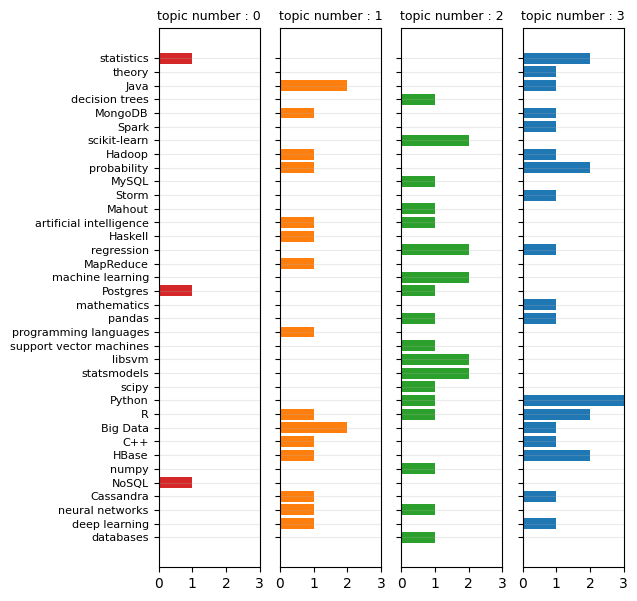

In [185]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6,7), sharey=True)

list_distinct_words = list(distinct_words)
color_list = ["tab:red", "tab:orange", "tab:green", "tab:blue"]

for topic_number in range(K):
  word_count = [topic_word_counts[topic_number][word] for word in list_distinct_words]

  axes[topic_number].barh(list_distinct_words, word_count, 
                          color=color_list[topic_number])

  axes[topic_number].set_title(f"topic number : {topic_number}", fontsize=9)

  axes[topic_number].yaxis.grid(True)
  axes[topic_number].set_yticks(np.arange(len(list_distinct_words)))
  axes[topic_number].set_yticklabels(list_distinct_words, rotation=0, ha="right", 
                      fontdict=dict(fontsize=8))
  axes[topic_number].set_xticks(np.arange(4))
  axes[topic_number].set_xticklabels([i for i in range(4)], fontdict=dict(fontsize=10))
  axes[topic_number].set_xlim([0, 3])

plt.subplots_adjust(hspace=0.5)
plt.show(fig)

Calculation of `topic_weights` at the end of LDA

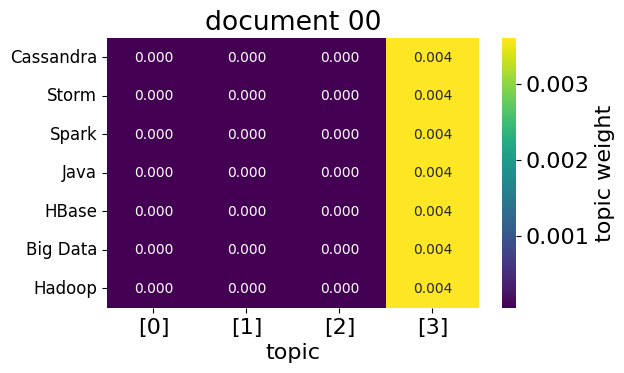

In [186]:
document_number = 0

fig, ax = plt.subplots(figsize=(6, 0.5*document_lengths[document_number]))

show_topic_count = True
# matrix_distinct_words_and_topics = np.zeros([len(distinct_words), K])
matrix_distinct_words_and_topics = np.zeros([document_lengths[document_number], K])

# for w, word in enumerate(distinct_words):
for w, word in zip(range(document_lengths[document_number]), documents[document_number]):
  for k in range(K):
    matrix_distinct_words_and_topics[w][k] = topic_weight(document_number, word, k)

sns.heatmap(matrix_distinct_words_and_topics, ax=ax, yticklabels=documents[document_number],
            xticklabels=np.arange(4), annot=show_topic_count, fmt=".3f",
            annot_kws=dict(fontsize=10),
            cbar_kws=dict(label="topic weight"), cmap="viridis")
ax.invert_yaxis()
ax.tick_params(axis="y", labelrotation=0, labelsize=12)
ax.set_title(f"document {document_number:02d}")

ax.set_xticks(np.arange(4) + 0.5)
ax.set_xticklabels([f"[{d}]" for d in range(4)])
ax.set_xlabel("topic")

plt.show(fig)


Let's look at the five most heavily weighted words for each topic or look   
at the above plot of distribution over distinct words

In [187]:
for k, word_counts in enumerate(topic_word_counts):
  for word, count in word_counts.most_common():
    if count > 0:
      print(k, word, count)

0 Postgres 1
0 statistics 1
0 NoSQL 1
1 Java 2
1 Big Data 2
1 MongoDB 1
1 R 1
1 probability 1
1 programming languages 1
1 neural networks 1
1 artificial intelligence 1
1 Hadoop 1
1 MapReduce 1
1 Cassandra 1
1 deep learning 1
1 HBase 1
1 C++ 1
1 Haskell 1
2 scikit-learn 2
2 statsmodels 2
2 machine learning 2
2 regression 2
2 libsvm 2
2 scipy 1
2 pandas 1
2 Mahout 1
2 Python 1
2 Postgres 1
2 numpy 1
2 neural networks 1
2 artificial intelligence 1
2 R 1
2 support vector machines 1
2 decision trees 1
2 databases 1
2 MySQL 1
3 Python 3
3 probability 2
3 HBase 2
3 R 2
3 statistics 2
3 Cassandra 1
3 Java 1
3 mathematics 1
3 C++ 1
3 deep learning 1
3 regression 1
3 MongoDB 1
3 theory 1
3 Hadoop 1
3 Big Data 1
3 pandas 1
3 Spark 1
3 Storm 1


In [188]:
# Create topic_names based the above output. This is a user defined
topic_names = ["databases and statistics",
               "programming language",
               "machine learning",
               "Big Data"]

This is the final topic assignment to each document

In [189]:
for document, topic_counts, document_topics_each_doc in zip(documents, document_topic_counts, document_topics):
  print(document)
  print(document_topics_each_doc)
  for topic, count in topic_counts.most_common():
    if count > 0:
      print(topic_names[topic], count)

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
[3, 3, 3, 3, 3, 3, 3]
Big Data 7
['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
[0, 1, 1, 1, 0]
programming language 3
databases and statistics 2
['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
[2, 2, 2, 2, 2, 2]
machine learning 6
['R', 'Python', 'statistics', 'regression', 'probability']
[3, 3, 3, 3, 3]
Big Data 5
['machine learning', 'regression', 'decision trees', 'libsvm']
[2, 2, 2, 2]
machine learning 4
['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
[3, 1, 1, 1, 1, 1]
programming language 5
Big Data 1
['statistics', 'probability', 'mathematics', 'theory']
[3, 3, 3, 3]
Big Data 4
['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
[2, 2, 2, 2]
machine learning 4
['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
[1, 1, 1, 1]
programming language 4
['Hadoop', 'Java', 'MapReduce', 'Big Data']
[1, 1, 1, 1]
programming language

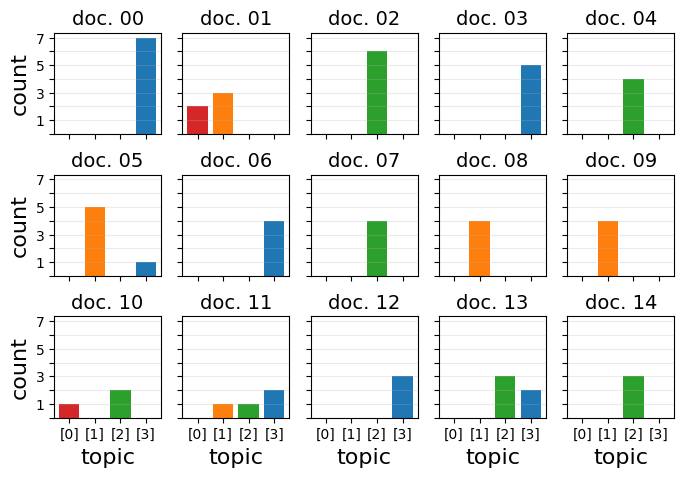

In [217]:
n_rows = 3
n_cols = 5

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, 5),
                          sharex=True, sharey=True)
list_colors = ["tab:red", "tab:orange", "tab:green", "tab:blue"]

for idx, (ax, document_number) in enumerate(zip(axes.flatten(), range(D))):

  document_d_topic_counts = [document_topic_counts[document_number][k] for k in range(K)]

  ax.bar(np.arange(4), document_d_topic_counts, color=list_colors)

  max_y_count = 8
  ax.set_yticks(np.arange(1, max_y_count, 2))
  ax.set_yticklabels([f"{count}" for count in range(1, max_y_count, 2)], fontdict=dict(fontsize=10))
  ax.set_xticks(np.arange(4))
  ax.set_xticklabels([f"[{k}]" for k in range(K)], fontdict=dict(fontsize=10))
  ax.yaxis.grid(True)
  if idx % n_cols == 0:
    ax.set_ylabel("count")
  
  if idx > (n_cols * n_rows - n_cols) - 1: 
    ax.set_xlabel("topic")
  
  ax.set_title(f"doc. {document_number:02}", fontsize=14)

  ax.yaxis.set_major_locator(MaxNLocator(integer=True))


plt.subplots_adjust(hspace=0.4)
plt.show(fig)

